# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20580 unique images.
- Approximately 150 images per breed.

# First, We Need to Prepare Libraries

In [1]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.4
TF Hub version: 0.12.0
GPU available


2022-08-18 04:55:25.591857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 04:55:25.706758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 04:55:25.707834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Preparation
## Retrieve the image classes (120 Unique Dog Breeds)

In [2]:
unique_breeds = []

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)
    
# Converts to sorted ndarray
unique_breeds = np.array(sorted(unique_breeds))
len(unique_breeds), unique_breeds[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'))

## Create a function to do all the pre-processing in one go (Data Pipeline)

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

#Image Data Pipeline Function
def image_data_pipeline(path, augment=False, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):
    """
    Reads images from path, and splits them into training and validation sets
    Create batches of data out of (image x) and (label y) pairs.
    Returns two data batches training_batch and validation_batch.

    Also accepts test data as input (no labels).
    """
    
    # Function for retrieving data
    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)
        
        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    #Function for preprocessing
    def process_image(filename, img_size=IMG_SIZE):
        #read image
        image = tf.io.read_file(filename)

        #turn jpeg to numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)

        #Convert colour channels values 0-255 to 0-1 values.
        #This is a normalization process to make process more efficient.
        image = tf.image.convert_image_dtype(image, tf.float32)

        #Resize to (224,224)
        image = tf.image.resize(image, size=[img_size, img_size])

        return image
    
    # Function for data configuration (for performance) 
    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000) 
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.RandomFlip(mode="horizontal")
    ])
    
    # ----------------------------------------------------------------------------------
    
    # Test data pipeline
    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)
    
    # Train and validation data pipeline
    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if augment:
            x_train = x_train.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            x_valid = x_valid.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train)) 
        valid_data = tf.data.Dataset.zip((x_valid, y_valid)) 
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)
  

## Generate Train and Validation Data for Base Training (No augmentation)

In [4]:
path = "../input/stanford-dogs-dataset/images/Images"
train_data, valid_data = image_data_pipeline(path)
train_data.element_spec, valid_data.element_spec

2022-08-18 05:10:39.381759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 05:10:39.382534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 05:10:39.383745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 05:10:39.384730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualize the generated image batches

2022-08-18 05:10:59.051580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


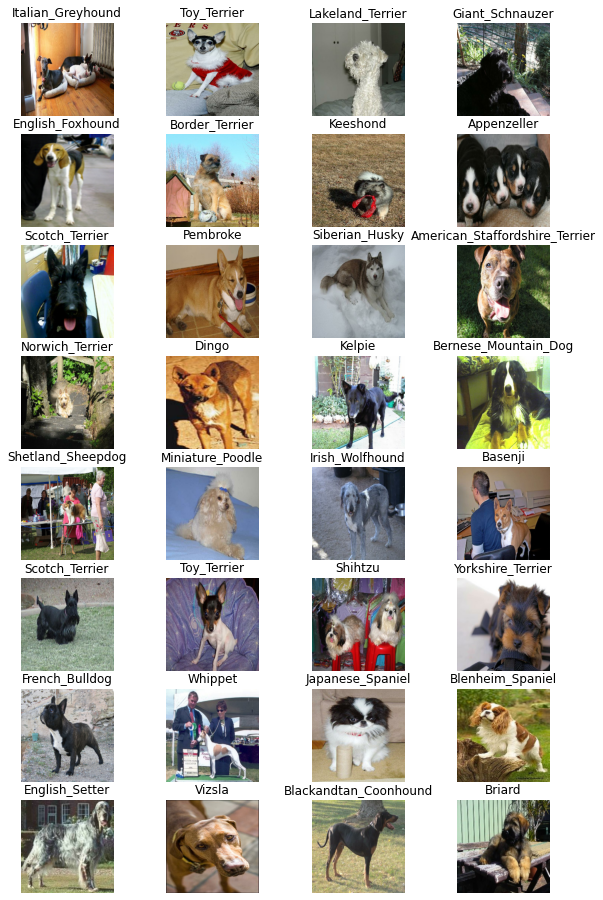

In [5]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

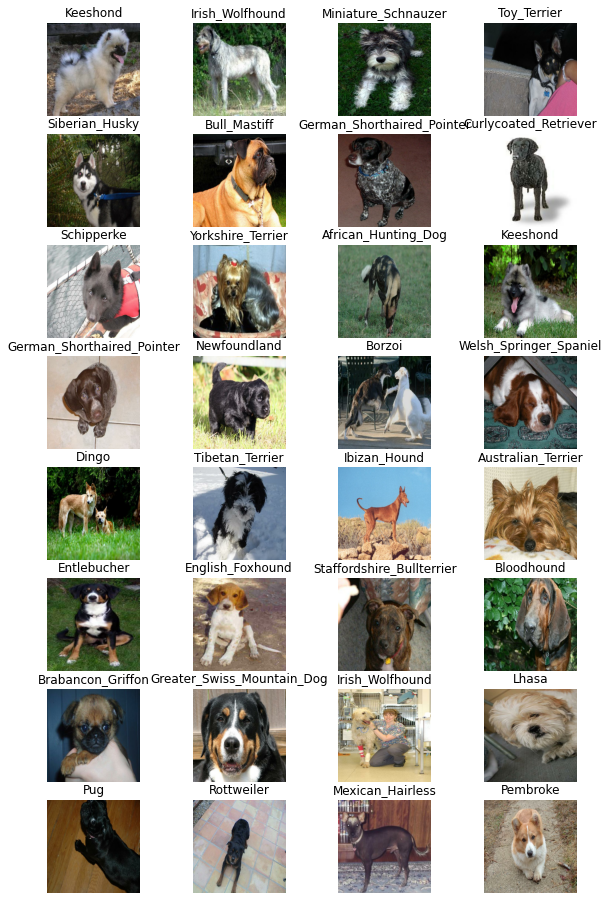

In [6]:
valid_image, valid_label = next(valid_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5

^^ MobileNetV3 ImageNet Feature Vectors (Size = 224x224, Depth Multiplier = 1.0)

In [7]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's:
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [8]:
# Extract Pre-trained base Model and freeze the layers
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5")
base_model.trainable = False
len(base_model.trainable_variables) # Shows that its frozen

0

In [9]:
# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 5,044,472
Trainable params: 818,040
Non-trainable params: 4,226,432
______________________________________

In [10]:
len(model.trainable_variables)

6

## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for Model Checkpoint, helps track and save our model
- Second is for early stopping, prevents model from training too long (becoming overfitted)

There is also a useful callback called TensorBoard but it is currently not working in Kaggle.
### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

### Model Checkpoint Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

In [11]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [12]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Train the model
## NOW, lets train the mode with the full data (20580 images)

In [13]:
init_loss, init_acc = model.evaluate(valid_data)

2022-08-18 05:11:33.167883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


129/129 [==============================] - 28s 160ms/step - loss: 4.8684 - accuracy: 0.0049


In [14]:
# Metrics before training (very poor performance)
print("initial loss: {:.2f}".format(init_loss))
print("initial accuracy: {:.2f}".format(init_acc))

initial loss: 4.87
initial accuracy: 0.00


In [16]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV3_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(x=train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs/Models/2022_08_18-05_20_1660800038-MobileNetV3_100_Adam_20580`
Epoch 1/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.4304 - accuracy: 0.8659

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.4287 - accuracy: 0.8674 - val_loss: 0.5487 - val_accuracy: 0.8224
Epoch 2/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.3837 - accuracy: 0.8777

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.3838 - accuracy: 0.8797 - val_loss: 0.5430 - val_accuracy: 0.8234
Epoch 3/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.3534 - accuracy: 0.8838

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.3395 - accuracy: 0.8910 - val_loss: 0.5345 - val_accuracy: 0.8333
Epoch 4/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.2990 - accuracy: 0.9085

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.2985 - accuracy: 0.9071 - val_loss: 0.5320 - val_accuracy: 0.8338
Epoch 5/100
 82/515 [===>..........................] - ETA: 37s - loss: 0.2719 - accuracy: 0.9173

Cleanup called...


515/515 [==============================] - 51s 94ms/step - loss: 0.2674 - accuracy: 0.9181 - val_loss: 0.5298 - val_accuracy: 0.8338
Epoch 6/100
 82/515 [===>..........................] - ETA: 35s - loss: 0.2440 - accuracy: 0.9272

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.2414 - accuracy: 0.9272 - val_loss: 0.5404 - val_accuracy: 0.8336
Epoch 7/100
 82/515 [===>..........................] - ETA: 35s - loss: 0.2254 - accuracy: 0.9314

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.2195 - accuracy: 0.9343 - val_loss: 0.5317 - val_accuracy: 0.8372
Epoch 8/100
 82/515 [===>..........................] - ETA: 35s - loss: 0.1989 - accuracy: 0.9425

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.1922 - accuracy: 0.9423 - val_loss: 0.5384 - val_accuracy: 0.8328
Epoch 9/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.1777 - accuracy: 0.9482

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.1735 - accuracy: 0.9479 - val_loss: 0.5495 - val_accuracy: 0.8358
Epoch 10/100
 81/515 [===>..........................] - ETA: 34s - loss: 0.1545 - accuracy: 0.9591

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.1528 - accuracy: 0.9555 - val_loss: 0.5524 - val_accuracy: 0.8358
Epoch 11/100
 82/515 [===>..........................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9581

Cleanup called...


515/515 [==============================] - 51s 94ms/step - loss: 0.1414 - accuracy: 0.9602 - val_loss: 0.5619 - val_accuracy: 0.8348
Epoch 12/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.1313 - accuracy: 0.9653

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.1264 - accuracy: 0.9648 - val_loss: 0.5617 - val_accuracy: 0.8375
Epoch 13/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.1233 - accuracy: 0.9657

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.1172 - accuracy: 0.9664 - val_loss: 0.5701 - val_accuracy: 0.8353
Epoch 14/100
 82/515 [===>..........................] - ETA: 35s - loss: 0.1010 - accuracy: 0.9737

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.1041 - accuracy: 0.9715 - val_loss: 0.5742 - val_accuracy: 0.8343
Epoch 15/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.0937 - accuracy: 0.9733

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.0950 - accuracy: 0.9738 - val_loss: 0.5814 - val_accuracy: 0.8379
Epoch 16/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.0898 - accuracy: 0.9756

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.0853 - accuracy: 0.9776 - val_loss: 0.5866 - val_accuracy: 0.8360
Epoch 17/100
 82/515 [===>..........................] - ETA: 33s - loss: 0.0784 - accuracy: 0.9756

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.0819 - accuracy: 0.9766 - val_loss: 0.5837 - val_accuracy: 0.8370
Epoch 18/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.0796 - accuracy: 0.9813

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0745 - accuracy: 0.9802 - val_loss: 0.5933 - val_accuracy: 0.8379
Epoch 19/100
 81/515 [===>..........................] - ETA: 34s - loss: 0.0728 - accuracy: 0.9838

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.0685 - accuracy: 0.9810 - val_loss: 0.6063 - val_accuracy: 0.8321
Epoch 20/100
 82/515 [===>..........................] - ETA: 37s - loss: 0.0656 - accuracy: 0.9844

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0621 - accuracy: 0.9843 - val_loss: 0.6072 - val_accuracy: 0.8375
Epoch 21/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.0507 - accuracy: 0.9882

Cleanup called...


515/515 [==============================] - 49s 92ms/step - loss: 0.0547 - accuracy: 0.9863 - val_loss: 0.6114 - val_accuracy: 0.8392
Epoch 22/100
 82/515 [===>..........................] - ETA: 37s - loss: 0.0533 - accuracy: 0.9863

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0518 - accuracy: 0.9875 - val_loss: 0.6243 - val_accuracy: 0.8353
Epoch 23/100
 82/515 [===>..........................] - ETA: 33s - loss: 0.0539 - accuracy: 0.9867

Cleanup called...


515/515 [==============================] - 49s 92ms/step - loss: 0.0489 - accuracy: 0.9883 - val_loss: 0.6352 - val_accuracy: 0.8348
Epoch 24/100
 82/515 [===>..........................] - ETA: 37s - loss: 0.0447 - accuracy: 0.9901

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0474 - accuracy: 0.9883 - val_loss: 0.6401 - val_accuracy: 0.8360
Epoch 25/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.0403 - accuracy: 0.9893

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.0434 - accuracy: 0.9896 - val_loss: 0.6472 - val_accuracy: 0.8362
Epoch 26/100
 82/515 [===>..........................] - ETA: 36s - loss: 0.0440 - accuracy: 0.9870

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.0405 - accuracy: 0.9902 - val_loss: 0.6515 - val_accuracy: 0.8348
Epoch 27/100
 82/515 [===>..........................] - ETA: 35s - loss: 0.0347 - accuracy: 0.9931

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0370 - accuracy: 0.9917 - val_loss: 0.6560 - val_accuracy: 0.8389
Epoch 28/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.0359 - accuracy: 0.9916

Cleanup called...


515/515 [==============================] - 51s 94ms/step - loss: 0.0350 - accuracy: 0.9922 - val_loss: 0.6695 - val_accuracy: 0.8319
Epoch 29/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.0343 - accuracy: 0.9928

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.0345 - accuracy: 0.9924 - val_loss: 0.6702 - val_accuracy: 0.8324
Epoch 30/100
 82/515 [===>..........................] - ETA: 32s - loss: 0.0288 - accuracy: 0.9943

Cleanup called...


515/515 [==============================] - 50s 92ms/step - loss: 0.0300 - accuracy: 0.9938 - val_loss: 0.6824 - val_accuracy: 0.8319
Epoch 31/100
 82/515 [===>..........................] - ETA: 34s - loss: 0.0297 - accuracy: 0.9920

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.0306 - accuracy: 0.9923 - val_loss: 0.6852 - val_accuracy: 0.8341


## Model Learning Curves (Accuracy/Loss)

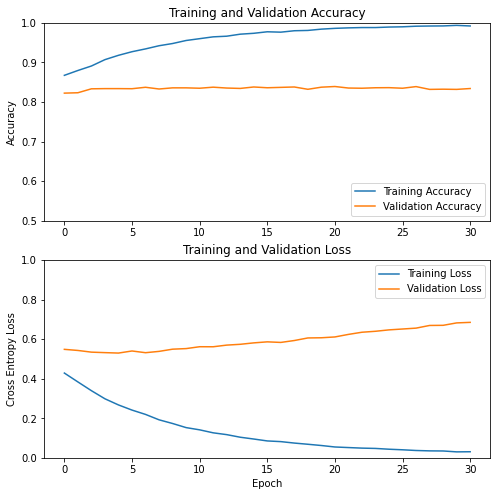

In [17]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

In [37]:
load_model = tf.keras.models.load_model("Notebook_Outputs/Models/2022_08_18-05_20_1660800038-MobileNetV3_100_Adam_20580")
base_loss, base_acc = load_model.evaluate(valid_data) #5814 8399

129/129 [==============================] - 11s 80ms/step - loss: 0.6114 - accuracy: 0.8392


In [24]:
# Metrics after training (decent performance)
print("{0:<10}|  {1:<10}{2:<10}".format("METRICS", "INITIAL", "TRAINED"))
print("-"*30)
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Accuracy", init_acc, base_acc))
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Loss", init_loss, base_loss))

METRICS   |  INITIAL   TRAINED   
------------------------------
Accuracy  |  0.00462   0.83989   
Loss      |  4.87709   0.58140   


# Data Augmentation

In [32]:
path = "../input/stanford-dogs-dataset/images/Images"
augment_train_data, augment_valid_data = image_data_pipeline(path, augment=True)
augment_train_data.element_spec, augment_valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

2022-08-18 06:01:41.047722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 943 of 1000
2022-08-18 06:01:41.658429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


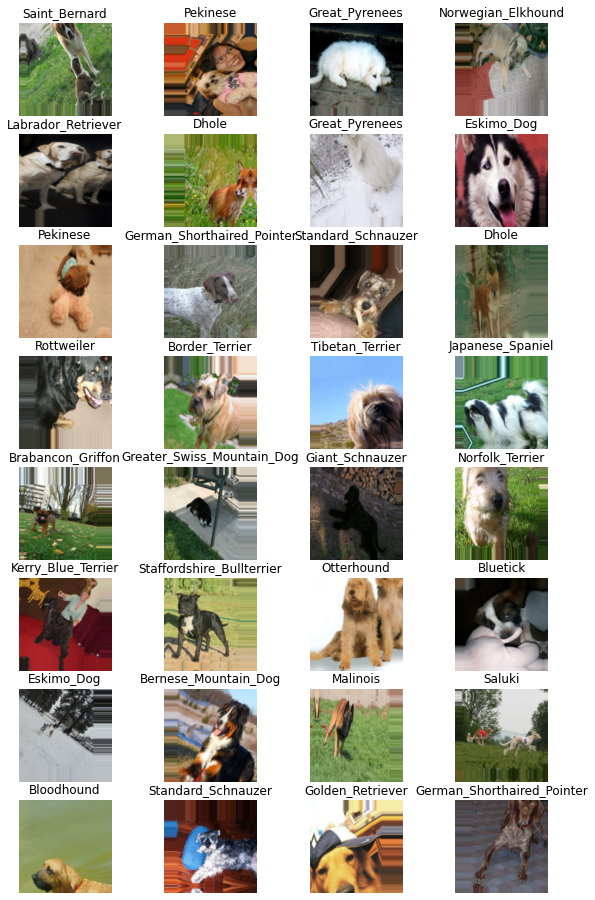

In [33]:
augment_train_image, augment_train_label = next(augment_train_data.as_numpy_iterator())
show_batch(augment_train_image, augment_train_label)

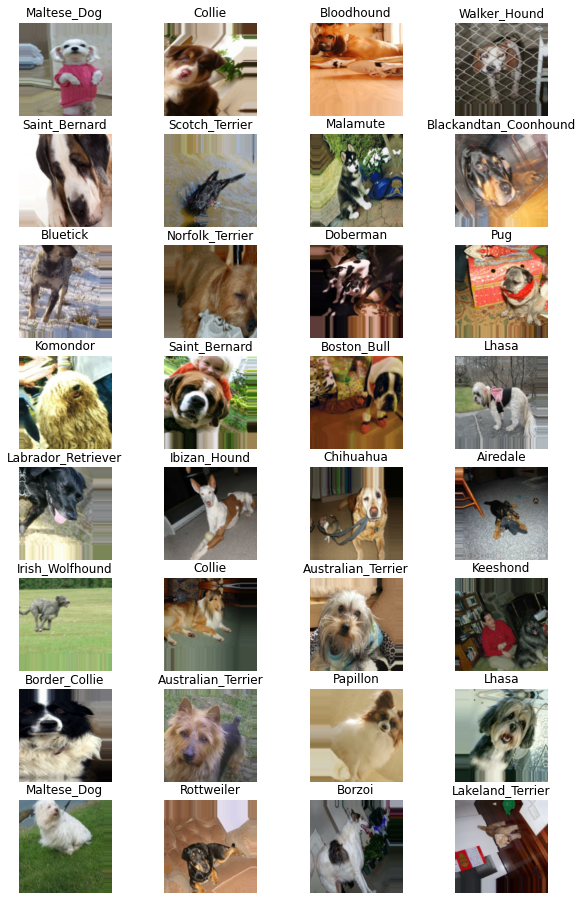

In [34]:
augment_val_image, augment_val_label = next(augment_valid_data.as_numpy_iterator())
show_batch(augment_val_image, augment_val_label)

In [ ]:
# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV2_100_Adam_20580_Augmented")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history_augment = load_model.fit(augment_train_data,
                             epochs=NUM_EPOCHS,
                             validation_data=augment_valid_data,
                             validation_freq=1,
                             callbacks=[early_stopping, checkpoint]
                              )

Model will be saved to `Notebook_Outputs/Models/2022_08_18-06_29_1660804174-MobileNetV2_100_Adam_20580_Augmented`
Epoch 1/100


2022-08-18 06:29:50.559337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 891 of 1000
2022-08-18 06:29:51.681444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 31s - loss: 1.0198 - accuracy: 0.7330

Cleanup called...


515/515 [==============================] - 233s 419ms/step - loss: 1.0095 - accuracy: 0.7340 - val_loss: 0.7340 - val_accuracy: 0.7843
Epoch 2/100


2022-08-18 06:33:42.258955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 891 of 1000
2022-08-18 06:33:43.432181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


423/515 [=======================>......] - ETA: 32s - loss: 0.8774 - accuracy: 0.7537

Cleanup called...


515/515 [==============================] - 229s 422ms/step - loss: 0.8790 - accuracy: 0.7516 - val_loss: 0.7183 - val_accuracy: 0.7918
Epoch 3/100


2022-08-18 06:38:04.189394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 919 of 1000
2022-08-18 06:38:05.411443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.8411 - accuracy: 0.7599

Cleanup called...


515/515 [==============================] - 229s 422ms/step - loss: 0.8431 - accuracy: 0.7591 - val_loss: 0.7148 - val_accuracy: 0.7908
Epoch 4/100


2022-08-18 06:41:52.993539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 951 of 1000
2022-08-18 06:41:53.521025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.7902 - accuracy: 0.7719

Cleanup called...


515/515 [==============================] - 229s 424ms/step - loss: 0.7980 - accuracy: 0.7707 - val_loss: 0.7156 - val_accuracy: 0.7898
Epoch 5/100


2022-08-18 06:46:14.923473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1000
2022-08-18 06:46:15.537331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.7599 - accuracy: 0.7789

Cleanup called...


515/515 [==============================] - 228s 422ms/step - loss: 0.7566 - accuracy: 0.7789 - val_loss: 0.7301 - val_accuracy: 0.7843
Epoch 6/100


2022-08-18 06:50:36.831065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 951 of 1000
2022-08-18 06:50:37.349477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.7338 - accuracy: 0.7818

Cleanup called...


515/515 [==============================] - 229s 424ms/step - loss: 0.7377 - accuracy: 0.7810 - val_loss: 0.7100 - val_accuracy: 0.7879
Epoch 7/100


2022-08-18 06:54:58.742812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 948 of 1000
2022-08-18 06:54:59.294555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.6994 - accuracy: 0.7906

Cleanup called...


515/515 [==============================] - 229s 425ms/step - loss: 0.7001 - accuracy: 0.7916 - val_loss: 0.7226 - val_accuracy: 0.7898
Epoch 8/100


2022-08-18 06:58:48.064816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 964 of 1000
2022-08-18 06:58:48.450841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


424/515 [=======================>......] - ETA: 32s - loss: 0.6855 - accuracy: 0.7959

Cleanup called...


515/515 [==============================] - 226s 420ms/step - loss: 0.6839 - accuracy: 0.7948 - val_loss: 0.7199 - val_accuracy: 0.7862
Epoch 9/100


2022-08-18 07:02:34.630886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 954 of 1000
2022-08-18 07:02:35.114984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


 69/515 [===>..........................] - ETA: 2:40 - loss: 0.6628 - accuracy: 0.8075

In [29]:
# Unfreeze the base layer
base_model.trainable = True

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              4226432   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               30840     
Total params: 5,044,472
Trainable params: 5,020,072
Non-trainable params: 24,400
_______________________________________

In [30]:
len(model.trainable_variables)

178

In [31]:
# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV2_100_Adam_20580_Finetuned")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history_fine = model.fit(train_data,
                             epochs=NUM_EPOCHS,
                             initial_epoch=model_history.epoch[-1],
                             validation_data=valid_data,
                             validation_freq=1,
                             callbacks=[early_stopping, checkpoint]
                              )

Model will be saved to `Notebook_Outputs/Models/2022_08_17-08_43_1660725820-MobileNetV2_100_Adam_20580_Finetuned`
Epoch 29/100
233/515 [============>.................] - ETA: 53s - loss: 1.4611 - accuracy: 0.6713

Cleanup called...


515/515 [==============================] - 129s 214ms/step - loss: 1.2372 - accuracy: 0.7278 - val_loss: 1.1981 - val_accuracy: 0.7413
Epoch 30/100
235/515 [============>.................] - ETA: 52s - loss: 0.8417 - accuracy: 0.8267

Cleanup called...


515/515 [==============================] - 111s 210ms/step - loss: 0.7740 - accuracy: 0.8438 - val_loss: 1.0624 - val_accuracy: 0.7767
Epoch 31/100
235/515 [============>.................] - ETA: 52s - loss: 0.6509 - accuracy: 0.8746

Cleanup called...


515/515 [==============================] - 111s 211ms/step - loss: 0.6194 - accuracy: 0.8856 - val_loss: 1.0001 - val_accuracy: 0.7889
Epoch 32/100
235/515 [============>.................] - ETA: 52s - loss: 0.5591 - accuracy: 0.9057

Cleanup called...


515/515 [==============================] - 110s 208ms/step - loss: 0.5417 - accuracy: 0.9085 - val_loss: 0.9696 - val_accuracy: 0.7957
Epoch 33/100
235/515 [============>.................] - ETA: 52s - loss: 0.5032 - accuracy: 0.9209

Cleanup called...


515/515 [==============================] - 110s 208ms/step - loss: 0.4935 - accuracy: 0.9237 - val_loss: 0.9514 - val_accuracy: 0.8030
Epoch 34/100
235/515 [============>.................] - ETA: 52s - loss: 0.4728 - accuracy: 0.9302

Cleanup called...


515/515 [==============================] - 111s 211ms/step - loss: 0.4615 - accuracy: 0.9353 - val_loss: 0.9408 - val_accuracy: 0.8083
Epoch 35/100
233/515 [============>.................] - ETA: 54s - loss: 0.4427 - accuracy: 0.9417

Cleanup called...


515/515 [==============================] - 112s 213ms/step - loss: 0.4349 - accuracy: 0.9433 - val_loss: 0.9383 - val_accuracy: 0.8110
Epoch 36/100
235/515 [============>.................] - ETA: 53s - loss: 0.4384 - accuracy: 0.9420

Cleanup called...


515/515 [==============================] - 111s 210ms/step - loss: 0.4234 - accuracy: 0.9478 - val_loss: 0.9328 - val_accuracy: 0.8117
Epoch 37/100
233/515 [============>.................] - ETA: 52s - loss: 0.4153 - accuracy: 0.9509

Cleanup called...


515/515 [==============================] - 112s 209ms/step - loss: 0.4056 - accuracy: 0.9542 - val_loss: 0.9349 - val_accuracy: 0.8137
Epoch 38/100
235/515 [============>.................] - ETA: 53s - loss: 0.3890 - accuracy: 0.9577

Cleanup called...


515/515 [==============================] - 120s 229ms/step - loss: 0.3836 - accuracy: 0.9608 - val_loss: 0.9317 - val_accuracy: 0.8166
Epoch 39/100
233/515 [============>.................] - ETA: 54s - loss: 0.3885 - accuracy: 0.9569

Cleanup called...


515/515 [==============================] - 113s 214ms/step - loss: 0.3814 - accuracy: 0.9599 - val_loss: 0.9350 - val_accuracy: 0.8139
Epoch 40/100
233/515 [============>.................] - ETA: 54s - loss: 0.3741 - accuracy: 0.9639

Cleanup called...


515/515 [==============================] - 112s 213ms/step - loss: 0.3699 - accuracy: 0.9654 - val_loss: 0.9357 - val_accuracy: 0.8205
Epoch 41/100
233/515 [============>.................] - ETA: 54s - loss: 0.3633 - accuracy: 0.9642

Cleanup called...


515/515 [==============================] - 113s 214ms/step - loss: 0.3611 - accuracy: 0.9662 - val_loss: 0.9395 - val_accuracy: 0.8178
Epoch 42/100
233/515 [============>.................] - ETA: 54s - loss: 0.3614 - accuracy: 0.9666

Cleanup called...


515/515 [==============================] - 113s 214ms/step - loss: 0.3559 - accuracy: 0.9684 - val_loss: 0.9404 - val_accuracy: 0.8195
Epoch 43/100
235/515 [============>.................] - ETA: 52s - loss: 0.3474 - accuracy: 0.9717

Cleanup called...


515/515 [==============================] - 112s 211ms/step - loss: 0.3449 - accuracy: 0.9730 - val_loss: 0.9396 - val_accuracy: 0.8180
Epoch 44/100
235/515 [============>.................] - ETA: 52s - loss: 0.3430 - accuracy: 0.9729

Cleanup called...


515/515 [==============================] - 111s 210ms/step - loss: 0.3402 - accuracy: 0.9739 - val_loss: 0.9497 - val_accuracy: 0.8173
Epoch 45/100
233/515 [============>.................] - ETA: 54s - loss: 0.3400 - accuracy: 0.9744

Cleanup called...


515/515 [==============================] - 113s 214ms/step - loss: 0.3358 - accuracy: 0.9757 - val_loss: 0.9527 - val_accuracy: 0.8185
Epoch 46/100
235/515 [============>.................] - ETA: 53s - loss: 0.3337 - accuracy: 0.9763

Cleanup called...


515/515 [==============================] - 114s 215ms/step - loss: 0.3301 - accuracy: 0.9770 - val_loss: 0.9561 - val_accuracy: 0.8185
Epoch 47/100
235/515 [============>.................] - ETA: 53s - loss: 0.3285 - accuracy: 0.9777

Cleanup called...


515/515 [==============================] - 114s 214ms/step - loss: 0.3262 - accuracy: 0.9788 - val_loss: 0.9569 - val_accuracy: 0.8171
Epoch 48/100
234/515 [============>.................] - ETA: 53s - loss: 0.3254 - accuracy: 0.9797

Cleanup called...


515/515 [==============================] - 111s 210ms/step - loss: 0.3224 - accuracy: 0.9798 - val_loss: 0.9629 - val_accuracy: 0.8146
Epoch 49/100
233/515 [============>.................] - ETA: 53s - loss: 0.3290 - accuracy: 0.9764

Cleanup called...


515/515 [==============================] - 112s 212ms/step - loss: 0.3239 - accuracy: 0.9788 - val_loss: 0.9616 - val_accuracy: 0.8200
Epoch 50/100
235/515 [============>.................] - ETA: 53s - loss: 0.3191 - accuracy: 0.9794

Cleanup called...


515/515 [==============================] - 112s 214ms/step - loss: 0.3152 - accuracy: 0.9817 - val_loss: 0.9566 - val_accuracy: 0.8168


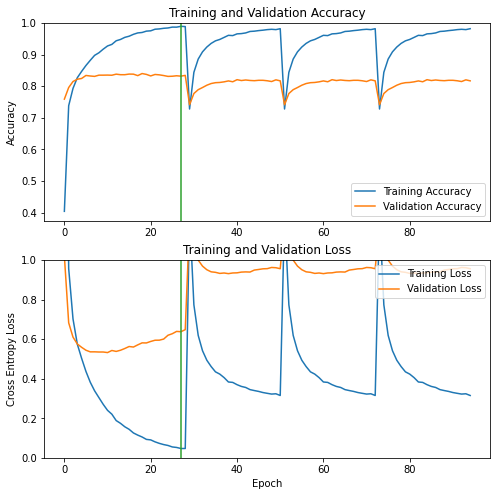

In [34]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss =model_history.history['val_loss']

acc += model_history_fine.history['accuracy']
val_acc += model_history_fine.history['val_accuracy']

loss += model_history_fine.history['loss']
val_loss += model_history_fine.history['val_loss']

# Plot
fig = plt.figure(figsize=(8,8))
ax_acc = plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.plot([27, 27], plt.ylim(), label="Start Fine Tuning")
plt.title("Training and Validation Accuracy",)


ax_loss = plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0,1.0])
plt.plot([27, 27], plt.ylim(), label="Start Fine Tuning")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, num of epochs to train for (`NUM_EPOCHS`), and callbacks
* Return Model

In [ ]:
NUM_EPOCHS = 100

def train_model(train_data, val_data, suffix=None, dir="Notebook_Outputs"):
    """
    Trains a given model and returns the trained version.
    """

    # Create model
    model = create_model()
    
    # Create new TensorBoard session everytime we train the model
    tensorboard = create_tensorboard_callback(dir)
    # Create new Model Checkpoint callback everytime we train the model
    checkpoint = create_model_checkpoint(dir, suffix)

    # Create early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)
    # Fit the model
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping, checkpoint],
            )
  
    # Return the fitted model
    return model

In [ ]:
# Create full model
full_model = train_model(train_data, valid_data, "MobileNetV3_100_Adam_20580")

### Checking the TensorBoard Logs

the Tensor board function `%tensorboard` will access the logs we created and visualize its content

In [ ]:
%tensorboard --logdir Logs

## Make a prediction using the trained model and evaluate VISUALLY

In [ ]:
# Make Predictions on validation data (not trained on)
preds = full_model.predict(valid_data, verbose=1)
preds

In [ ]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

get_pred_label(preds[0])

In [ ]:
unbatched_image, unbatched_label = next(valid_data.as_numpy_iterator())
unbatched_image[0], unbatched_label[0]

In [ ]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {get_pred_label(unbatched_label[index])}")

In [ ]:
preds_check(0)

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)
  true_label = get_pred_label(true_label)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

In [ ]:
plot_pred(preds,unbatched_label,unbatched_image, 10)

In [ ]:
plot_pred_conf(preds, unbatched_label, 10)

## Reloading a trained model

In [ ]:
# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model

In [ ]:
# Load a model trained on 1200 images
loaded_1200_image_model = load_model("Models/2022_08_15-06_28_1660544933-MobileNetV3_100_Adam_20580")

In [ ]:
loaded_1200_image_model.evaluate(valid_data)

# Fine-tuning the model
## To start off, lets try training 1200 images first. (10 of each class for balance)
We don't repetitively train the entire image data because it will take time and won't be efficient for the finetuning process.
Therefore, starting with smaller amounts would be Faster and more convenient for finetuning.

We will be taking these images from the `./experiment_data/` folder which will created below.

# Data Augmentation for further improvement on model (Enrichment of training data)